In [1]:
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision.datasets import ImageFolder

In [2]:
cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))

Files in '/content': ['.config', 'sample_data']


In [3]:
%cd /home

/home


In [4]:
%mkdir /home/seg_train
%mkdir /home/seg_train/buildings
!git clone https://github.com/fafilia/cnn-intel_images.git
!cp -r cnn-intel_images/seg_train/buildings/* /home/seg_train/buildings/

Cloning into 'cnn-intel_images'...
remote: Enumerating objects: 24329, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 24329 (delta 2), reused 5 (delta 2), pack-reused 24323
Receiving objects: 100% (24329/24329), 351.65 MiB | 31.24 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Updating files: 100% (24341/24341), done.


In [5]:
TRAIN_DATA_PATH = "/home/cnn-intel_images/seg_train"
TEST_DATA_PATH = "/home/cnn-intel_images/seg_test"

transformed_data = transforms.Compose(
    [
        transforms.Resize((64,64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

    ]
)


train_data = ImageFolder(TRAIN_DATA_PATH, transform = transformed_data )
test_data = ImageFolder(TEST_DATA_PATH, transform = transformed_data )

In [6]:
train_data

Dataset ImageFolder
    Number of datapoints: 14034
    Root location: /home/cnn-intel_images/seg_train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [7]:
# Hyperparameters
num_epochs = 20
batch_size = 32
learning_rate = 0.001

In [8]:
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data)

In [9]:
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.layer3 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.drop_out = nn.Dropout()
    self.fc1 = nn.Linear(8 * 8 * 64, 512)
    self.fc2 = nn.Linear(512, 128)
    self.fc3 = nn.Linear(128, 32)
    self.fc4 = nn.Linear(32, 6)

  def forward(self, x):
      out = self.layer1(x)
      out = self.layer2(out)
      out = self.layer3(out)
      # print('out',out)
      out = out.reshape(out.size(0), -1)
      out = self.drop_out(out)
      out = self.fc1(out)
      out = self.fc2(out)
      out = self.fc3(out)
      out = self.fc4(out)
      return out


In [10]:
model = ConvNet()

In [11]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
# Train the model
total_step = len(train_loader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Run the forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1) # find the class with the highest score (the predicted class) for each input in the batch
        # print('torch max', torch.max(outputs.data, 1))
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/20], Step [100/439], Loss: 0.7184, Accuracy: 81.25%
Epoch [1/20], Step [200/439], Loss: 0.9981, Accuracy: 59.38%
Epoch [1/20], Step [300/439], Loss: 1.0840, Accuracy: 53.12%
Epoch [1/20], Step [400/439], Loss: 0.5494, Accuracy: 81.25%
Epoch [2/20], Step [100/439], Loss: 0.5773, Accuracy: 75.00%
Epoch [2/20], Step [200/439], Loss: 0.6200, Accuracy: 78.12%
Epoch [2/20], Step [300/439], Loss: 0.8027, Accuracy: 71.88%
Epoch [2/20], Step [400/439], Loss: 0.9082, Accuracy: 71.88%
Epoch [3/20], Step [100/439], Loss: 0.6570, Accuracy: 75.00%
Epoch [3/20], Step [200/439], Loss: 0.7768, Accuracy: 59.38%
Epoch [3/20], Step [300/439], Loss: 0.8092, Accuracy: 75.00%
Epoch [3/20], Step [400/439], Loss: 0.8767, Accuracy: 65.62%
Epoch [4/20], Step [100/439], Loss: 0.9096, Accuracy: 71.88%
Epoch [4/20], Step [200/439], Loss: 0.3806, Accuracy: 81.25%
Epoch [4/20], Step [300/439], Loss: 0.6980, Accuracy: 71.88%
Epoch [4/20], Step [400/439], Loss: 0.6714, Accuracy: 65.62%
Epoch [5/20], Step [100/

In [16]:
model.state_dict()

OrderedDict([('layer1.0.weight',
              tensor([[[[-9.2526e-02,  1.2633e-01,  8.8423e-03, -9.1201e-02, -1.0532e-02],
                        [-6.6574e-02,  1.6522e-01,  6.5760e-02,  9.1322e-02,  1.2023e-02],
                        [-2.3530e-01, -9.3578e-02, -5.7865e-02,  1.2734e-01, -6.7671e-02],
                        [-1.1403e-01,  1.4581e-01,  8.4951e-02, -1.4464e-01,  3.9947e-02],
                        [-1.3717e-01,  6.8323e-02,  3.9322e-02,  9.4333e-03,  2.4616e-02]],
              
                       [[-3.7499e-02,  1.7959e-01, -2.8139e-02, -4.3460e-02,  6.8135e-02],
                        [-1.8180e-01,  2.1384e-01,  1.5165e-01, -4.2644e-02, -8.0398e-02],
                        [-2.4524e-01,  3.6855e-02,  1.1519e-01,  1.7932e-01,  6.1293e-02],
                        [-5.7034e-02,  1.5860e-01,  7.1087e-02,  2.5616e-02, -6.8410e-02],
                        [-1.8775e-01, -8.7952e-02,  5.5389e-02,  1.0222e-02,  8.0968e-02]],
              
                       [[

In [21]:
# Saving the model
torch.save(model.state_dict(), 'best_model.pth')

In [22]:
model = ConvNet()
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [24]:
model.eval()
results = []
image_list = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        results.append(predicted)
        image_list.append(images)

    print('Test Accuracy of the model on the test images: {} %'.format((correct / total) * 100))



Test Accuracy of the model on the test images: 81.23333333333333 %


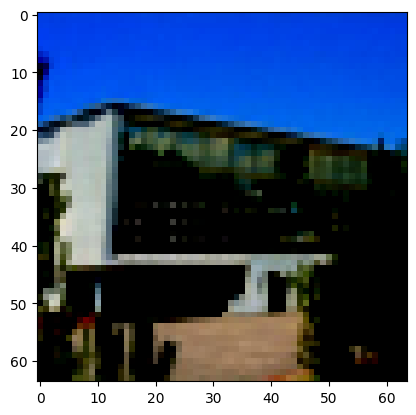

In [31]:
import matplotlib.pyplot as plt
img_np = image_list[6].numpy().transpose((2, 3, 1, 0))   # new dim : (64,64,3,1)
plt.imshow(img_np.squeeze())
plt.show()

In [27]:
# classes:

# 'buildings' -> 0
# 'forest'    -> 1
# 'glacier'   -> 2
# 'mountain'  -> 3
# 'sea'       -> 4
# 'street'    -> 5

In [28]:
results[6]

tensor([0])